In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# install Transformers

In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 5.1 MB/s 
     |████████████████████████████████| 163 kB 45.2 MB/s 
     |████████████████████████████████| 7.6 MB 43.2 MB/s 


# Import

In [ ]:
from transformers import AutoModel
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import gc

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import transformers
print('transformers version :', transformers.__version__)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transformers version : 4.23.1


# Config(구성)
#### 인코더를 고정 / 고정하지 않고 두번 훈련

In [ ]:
config = {
    'model' : 'bert-base-uncased',
    'dropout' : 0.1,
    'max_length' : 512,
    'batch_size' : 16,
    'epochs' : 100,
    'freeze_lr' : 3e-3,
    'unfreeze_lr': 3e-5,
    'device':'cuda' if torch.cuda.is_available() else 'cpu',
    'scheduler': 'ConsineAnnealingWarmRestarts',
    'gradient_accumulation_steps' : 2,
    'adam_eps' : 1e-6,
    'freeze_encoder' : False,
    'trn_fold': [0, 1, 2, 3],
    'target_cols' : ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions'],
    'lr_patience' : 10,
}

# Tokenizer, Dataset and DataLoaders

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ㄱ/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/ㄱ/test.csv')

In [ ]:
test_df.head()

,text_id,full_text
0,0000C359D63E,when a person has no experience on a job their...
1,000BAD50D026,Do you think students would benefit from being...
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde..."


In [ ]:
print(df.columns.to_list())

['text_id', 'full_text', 'cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']


In [ ]:
class EssayDataset:
    def __init__(self, df, config, tokenizer=None, is_test=False):
        self.df = df.reset_index(drop=True)
        self.classes = ['cohesion','syntax','vocabulary','phraseology','grammar','conventions']
        self.max_len = config['max_length']
        self.tokenizer = tokenizer
        self.is_test = is_test
        
    def __getitem__(self,idx):
        sample = self.df['full_text'][idx]
        tokenized = tokenizer.encode_plus(sample,
                                         None,
                                         add_special_tokens=True,
                                         max_length=self.max_len,
                                         truncation=True,
                                         padding='max_length'
                                         )
        inputs = {
            "input_ids" : torch.tensor(tokenized['input_ids'], dtype=torch.long),
            "token_type_ids" : torch.tensor(tokenized['token_type_ids'], dtype=torch.long),
            "attention_mask" : torch.tensor(tokenized['attention_mask'], dtype=torch.long)
        }
        
        if self.is_test == True:
            return inputs
        
        label = self.df.loc[idx, self.classes].to_list()
        targets = {
            "labels" : torch.tensor(label, dtype=torch.float32),
        }
        
        return inputs, targets
    
    def __len__(self):
        return len(self.df)

In [ ]:
train_df, val_df = train_test_split(df,test_size=0.2,random_state=1357,shuffle=True)
print('dataframe shape:',train_df.shape, val_df.shape)

dataframe shape: (3128, 8) (783, 8)


In [ ]:
train_ds = EssayDataset(train_df, config, tokenizer=tokenizer)
val_ds = EssayDataset(val_df, config, tokenizer=tokenizer)
test_ds = EssayDataset(test_df, config, tokenizer=tokenizer, is_test=True)

In [ ]:
train_ds[0][0]['input_ids'].shape

torch.Size([512])

In [ ]:
train_loader = torch.utils.data.DataLoader(train_ds,
                                          batch_size=config['batch_size'],
                                          shuffle=True,
                                          num_workers=2,
                                          pin_memory=True
                                          )
val_loader = torch.utils.data.DataLoader(val_ds,
                                        batch_size=config['batch_size'],
                                        shuffle=True,
                                        num_workers=2,
                                        pin_memory=True
                                        )

In [ ]:
print('loader shapes:',len(train_loader), len(val_loader))

loader shapes: 196 49


# Model 1 : Unfreezed Encoder

In [ ]:
class EssayModel(nn.Module):
    def __init__(self, config,num_classes=6):
        super(EssayModel,self).__init__()
        self.model_name = config['model']
        self.encoder = AutoModel.from_pretrained(self.model_name)
        self.dropout = nn.Dropout(config['dropout'])
        self.fc1 = nn.Linear(self.encoder.config.hidden_size,64)
        self.fc2 = nn.Linear(64, num_classes)
        
    def forward(self,inputs):
        _, outputs = self.encoder(**inputs, return_dict=False)
        outputs = self.dropout(outputs)
        outputs = self.fc1(outputs)
        outputs = self.fc2(outputs)
        return outputs

# Model 2 : Freezed Encoder

In [ ]:
class FrozenEssayModel(nn.Module):
    def __init__(self,config,num_classes=6):
        super(FrozenEssayModel,self).__init__()
        self.model_name = config['model']
        self.encoder = AutoModel.from_pretrained(self.model_name)
        
        for param in self.encoder.base_model.parameters():
            param.requires_grad = False
            
        self.dropout = nn.Dropout(config['dropout'])
        self.fc1 = nn.Linear(self.encoder.config.hidden_size,64)
        self.fc2 = nn.Linear(64,num_classes)
        
    def forward(self,inputs):
        _,outputs = self.encoder(**inputs, return_dict=False)
        outputs = self.dropout(outputs)
        outputs = self.fc1(outputs)
        outputs = self.fc2(outputs)
        return outputs

# EarlyStopping

In [ ]:
# import EarlyStopping
# from pytorchtools import EarlyStopping
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# Trainer

In [ ]:
class Trainer:
    def __init__(self, model, loaders, config, lr='unfreeze'):
        self.model = model
        self.train_loader, self.val_loader = loaders
        self.config = config
        self.input_keys = ['input_ids', 'token_type_ids', 'attention_mask']
        
        self.loss_fn = nn.SmoothL1Loss()
        
        if lr == 'unfreeze':
            self.lr = self.config['unfreeze_lr']
        else:
            self.lr = self.config['freeze_lr']
            
        self.optim = self._get_optim()
        
        self.scheduler_options = {
            'ConsineAnnealingWarmRestarts' : torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(self.optim, T_0=5, eta_min=1e-7),
            'ReduceLROnPlateau' : torch.optim.lr_scheduler.ReduceLROnPlateau(self.optim, 'min', min_lr=1e-7),
            'StepLR' : torch.optim.lr_scheduler.StepLR(self.optim,step_size=2)
        }
        
        self.scheduler = self.scheduler_options[self.config['scheduler']]
        
        self.train_losses = []
        self.val_losses = []
        self.val_mcrmse = []
        
    def _get_optim(self):
        no_decay = ['bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params':[p for n, p in self.model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
            {'params':[p for n, p in self.model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
        optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=self.lr)
        return optimizer
    
    def mcrmse(self, outputs, targets):
        colwise_mse = torch.mean(torch.square(targets - outputs), dim=0)
        loss = torch.mean(torch.sqrt(colwise_mse), dim=0)
        return loss
    
    def train_one_epoch(self,epoch):
        
        running_loss = 0.
        progress = tqdm(self.train_loader, total=len(self.train_loader))
        
        for i,(inputs,targets) in enumerate(progress):
            self.optim.zero_grad()
            
            inputs = {k:inputs[k].to(device=config['device']) for k in inputs.keys()}
            targets = targets['labels'].to(device=config['device'])
            
            outputs = self.model(inputs)
            
            loss = self.loss_fn(outputs, targets)
            running_loss += loss.item()
            
            loss.backward()
            self.optim.step()
            
            if self.config['scheduler'] == 'ConsineAnnealingWarmRestarts':
                self.scheduler.step(epoch-1+i/len(self.train_loader))
                
            del inputs, targets, outputs, loss
            
        if self.config['scheduler'] == 'StepLR':
            self.scheduler.step()
            
        train_loss = running_loss/len(self.train_loader)
        self.train_losses.append(train_loss)
        
    @torch.no_grad()
    def valid_one_epoch(self,epoch):
        
        running_loss = 0.
        running_mcrmse = 0.
        progress = tqdm(self.val_loader, total=len(self.val_loader))
        
        for (inputs, targets) in progress:
            
            inputs = {k:inputs[k].to(device=config['device']) for k in inputs.keys()}
            targets = targets['labels'].to(device=config['device'])
            
            outputs = self.model(inputs)
            
            loss = self.loss_fn(outputs, targets)
            running_loss += loss.item()
            
            running_mcrmse += self.mcrmse(outputs, targets).item()
            
            del inputs, targets, outputs, loss
            
        val_loss = running_loss/len(self.val_loader)
        self.val_losses.append(val_loss)
        
        self.val_mcrmse.append(running_mcrmse/len(self.val_loader))
        del running_mcrmse
        
        if config['scheduler'] == 'ReduceLROnPlateau':
            self.scheduler.step(val_loss)
            
    def test(self, test_loader):
            
        preds = []
        for (inputs) in test_loader:
            inputs = {k:inputs[k].to(device=config['device']) for k in inputs.keys()}
            outputs = self.model(inputs)
            preds.append(outputs.detach().cpu())
                
        preds = torch.concat(preds)
        return preds
        
    def fit(self):
            
        fit_progress = tqdm(
            range(1, self.config['epochs']+1),
            leave = True,
            desc = "Training..."
        )
        self.early_stopping = EarlyStopping(patience = self.config['lr_patience'], verbose = True)
            
        for epoch in fit_progress:
                
            self.model.train()
            fit_progress.set_description(f"EPOCH {epoch} / {self.config['epochs']}| training...")
            self.train_one_epoch(epoch)
            self.clear()

            self.model.eval()
            fit_progress.set_description(f"EPOCH {epoch} / {self.config['epochs']}| validating...")
            self.valid_one_epoch(epoch)
            self.clear()

            print(f"{'-'*30} EPOCH {epoch} / {self.config['epochs']} {'-'*30}")
            print(f"train loss: {self.train_losses[-1]}")
            print(f"valid loss: {self.val_losses[-1]}\n\n")

            self.early_stopping(self.val_losses[-1], self.model)
            
            if self.early_stopping.early_stop:
              print("Early stopping")
              break
            
    def get_model(self):
        # best model이 저장되어있는 last checkpoint를 로드한다.
        self.model.load_state_dict(torch.load('checkpoint.pt'))

        return self.model
                
    def clear(self):
        gc.collect()
        torch.cuda.empty_cache()

# Training

In [ ]:
model = EssayModel(config).to(device=config['device'])
trainer_unfreeze = Trainer(model, (train_loader, val_loader), config, lr='unfreeze')

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

KeyboardInterrupt: ignored

In [ ]:
trainer_unfreeze.fit()

In [ ]:
unfreeze_model = trainer_unfreeze.get_model()

### Unfreezed Encoder Mode

In [ ]:
list(range(1, config['lr_patience'] + 7))

In [ ]:
losses_df = pd.DataFrame({
                          'train_loss':trainer_unfreeze.train_losses,
                          'val_loss':trainer_unfreeze.val_losses,
                          'val_mcrmse': trainer_unfreeze.val_mcrmse
                         })
losses_df.index = losses_df.index+1
losses_df

In [ ]:
plt.plot(trainer_unfreeze.train_losses, color='red')
plt.plot(trainer_unfreeze.val_losses, color='orange')
plt.title('MCRMSE Loss: Unfreezed Encoder')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

#Unfreeze_Inference

In [ ]:
test_df = pd.read_csv("/content/drive/MyDrive/ㄱ/test.csv")
submission = pd.read_csv("/content/drive/MyDrive/ㄱ/sample_submission.csv")
df_INNER_JOIN = pd.merge(test_df, submission, left_on='text_id', right_on='text_id', how='inner')
test_df = df_INNER_JOIN
test_df

In [ ]:
def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [ ]:
test_loader = torch.utils.data.DataLoader(test_ds,
                         batch_size=config['batch_size'],
                         shuffle=False, num_workers=2, pin_memory=True)
predictions = []
for fold in range(1):
    # model = DebertaModel(config)
    # state = torch.load('checkpoint.pt',
    #                    map_location=torch.device('cpu'))
    #model.load_state_dict(state['model'])
    prediction = inference_fn(test_loader, model, device)
    predictions.append(prediction)
    del prediction; gc.collect()
    torch.cuda.empty_cache()
predictions = np.mean(predictions, axis=0)

In [ ]:
test_df[config['target_cols']] = predictions
test_df

# model 초기화

In [ ]:
del model
gc.collect()
torch.cuda.empty_cache()

## Freezed Encoder Model

In [ ]:
model = FrozenEssayModel(config).to(device=config['device'])
trainer_freeze = Trainer(model, (train_loader, val_loader), config, lr='freeze')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
trainer_freeze.fit()

Training...:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

------------------------------ EPOCH 1 / 100 ------------------------------
train loss: 0.2265471129165012
valid loss: 0.17275691306104465


Validation loss decreased (inf --> 0.172757).  Saving model ...


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

------------------------------ EPOCH 2 / 100 ------------------------------
train loss: 0.16683279928200098
valid loss: 0.1372253253143661


Validation loss decreased (0.172757 --> 0.137225).  Saving model ...


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

------------------------------ EPOCH 3 / 100 ------------------------------
train loss: 0.1504175715832686
valid loss: 0.1393576989672622


EarlyStopping counter: 1 out of 10


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

------------------------------ EPOCH 4 / 100 ------------------------------
train loss: 0.1417090361367683
valid loss: 0.144485204499595


EarlyStopping counter: 2 out of 10


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

------------------------------ EPOCH 5 / 100 ------------------------------
train loss: 0.13771606517993673
valid loss: 0.14587166464450407


EarlyStopping counter: 3 out of 10


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

------------------------------ EPOCH 6 / 100 ------------------------------
train loss: 0.16392488161824187
valid loss: 0.15508462443035476


EarlyStopping counter: 4 out of 10


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

------------------------------ EPOCH 7 / 100 ------------------------------
train loss: 0.1527991746077124
valid loss: 0.15573574906709242


EarlyStopping counter: 5 out of 10


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

------------------------------ EPOCH 8 / 100 ------------------------------
train loss: 0.14448583973761725
valid loss: 0.1682491959357748


EarlyStopping counter: 6 out of 10


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

------------------------------ EPOCH 9 / 100 ------------------------------
train loss: 0.13853767860148633
valid loss: 0.13377942889928818


Validation loss decreased (0.137225 --> 0.133779).  Saving model ...


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

------------------------------ EPOCH 10 / 100 ------------------------------
train loss: 0.13484492071200999
valid loss: 0.14481943085485574


EarlyStopping counter: 1 out of 10


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

------------------------------ EPOCH 11 / 100 ------------------------------
train loss: 0.15513846251581395
valid loss: 0.13246443837272878


Validation loss decreased (0.133779 --> 0.132464).  Saving model ...


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

------------------------------ EPOCH 12 / 100 ------------------------------
train loss: 0.15071899846804385
valid loss: 0.17317158987327497


EarlyStopping counter: 1 out of 10


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

------------------------------ EPOCH 13 / 100 ------------------------------
train loss: 0.1447909856405185
valid loss: 0.16809150090022962


EarlyStopping counter: 2 out of 10


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

------------------------------ EPOCH 14 / 100 ------------------------------
train loss: 0.138652522687097
valid loss: 0.1377272028095868


EarlyStopping counter: 3 out of 10


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

------------------------------ EPOCH 15 / 100 ------------------------------
train loss: 0.13440339301465726
valid loss: 0.14004113023378412


EarlyStopping counter: 4 out of 10


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

------------------------------ EPOCH 16 / 100 ------------------------------
train loss: 0.14927539658941785
valid loss: 0.12892390194596076


Validation loss decreased (0.132464 --> 0.128924).  Saving model ...


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

------------------------------ EPOCH 17 / 100 ------------------------------
train loss: 0.1498378134351604
valid loss: 0.1410324401697334


EarlyStopping counter: 1 out of 10


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

------------------------------ EPOCH 18 / 100 ------------------------------
train loss: 0.1410154581678157
valid loss: 0.1472239672225349


EarlyStopping counter: 2 out of 10


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

------------------------------ EPOCH 19 / 100 ------------------------------
train loss: 0.13825339192942698
valid loss: 0.1312186020065327


EarlyStopping counter: 3 out of 10


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

------------------------------ EPOCH 20 / 100 ------------------------------
train loss: 0.13465669720756765
valid loss: 0.14096443172620268


EarlyStopping counter: 4 out of 10


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

------------------------------ EPOCH 21 / 100 ------------------------------
train loss: 0.15438324395491151
valid loss: 0.13958723675839754


EarlyStopping counter: 5 out of 10


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

------------------------------ EPOCH 22 / 100 ------------------------------
train loss: 0.1479474586263603
valid loss: 0.13734536922099638


EarlyStopping counter: 6 out of 10


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

------------------------------ EPOCH 23 / 100 ------------------------------
train loss: 0.14284423373791635
valid loss: 0.15090155084522403


EarlyStopping counter: 7 out of 10


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

------------------------------ EPOCH 24 / 100 ------------------------------
train loss: 0.139884583994138
valid loss: 0.14775983441849144


EarlyStopping counter: 8 out of 10


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

------------------------------ EPOCH 25 / 100 ------------------------------
train loss: 0.1331951484008103
valid loss: 0.1402917726307499


EarlyStopping counter: 9 out of 10


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

------------------------------ EPOCH 26 / 100 ------------------------------
train loss: 0.14969793950416604
valid loss: 0.13447973436238814


EarlyStopping counter: 10 out of 10
Early stopping


In [ ]:
model = trainer_freeze.get_model()

# Results

### Freezed Encoder Model

In [ ]:
losses_df = pd.DataFrame({
                         'train_loss':trainer_freeze.train_losses,
                         'val_loss': trainer_freeze.val_losses,
                         'val_mcrmse': trainer_freeze.val_mcrmse
                         })

losses_df.index = losses_df.index+1
losses_df

,train_loss,val_loss,val_mcrmse
1,0.226547,0.172757,0.584426
2,0.166833,0.137225,0.517604
3,0.150418,0.139358,0.522518
4,0.141709,0.144485,0.532971
5,0.137716,0.145872,0.536094
6,0.163925,0.155085,0.552248
7,0.152799,0.155736,0.552933
8,0.144486,0.168249,0.577581
9,0.138538,0.133779,0.511928
10,0.134845,0.144819,0.533817


### Plots

# Freeze Losses

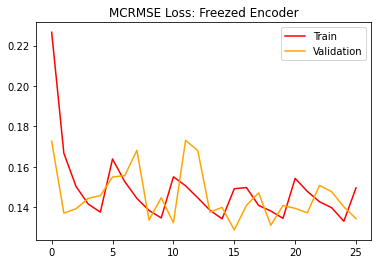

In [ ]:
plt.plot(trainer_freeze.train_losses, color='red')
plt.plot(trainer_freeze.val_losses, color='orange')
plt.title('MCRMSE Loss: Freezed Encoder')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Inference

In [ ]:
test_df = pd.read_csv("/content/drive/MyDrive/ㄱ/test.csv")
submission = pd.read_csv("/content/drive/MyDrive/ㄱ/sample_submission.csv")
df_INNER_JOIN = pd.merge(test_df, submission, left_on='text_id', right_on='text_id', how='inner')
test_df = df_INNER_JOIN
test_df

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,when a person has no experience on a job their...,3.0,3.0,3.0,3.0,3.0,3.0
1,000BAD50D026,Do you think students would benefit from being...,3.0,3.0,3.0,3.0,3.0,3.0
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde...",3.0,3.0,3.0,3.0,3.0,3.0


In [ ]:
def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [ ]:
test_loader = torch.utils.data.DataLoader(test_ds,
                         batch_size=config['batch_size'],
                         shuffle=False, num_workers=2, pin_memory=True)
predictions = []
for fold in range(1):
    # model = DebertaModel(config)
    # state = torch.load('checkpoint.pt',
    #                    map_location=torch.device('cpu'))
    #model.load_state_dict(state['model'])
    prediction = inference_fn(test_loader, model, device)
    predictions.append(prediction)
    del prediction; gc.collect()
    torch.cuda.empty_cache()
predictions = np.mean(predictions, axis=0)

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
predictions 

array([[2.927888 , 2.9056537, 3.269734 , 2.9811935, 2.7410336, 2.920313 ],
       [2.4927843, 2.350111 , 2.5713353, 2.3132193, 2.0789652, 2.4999466],
       [3.558516 , 3.63098  , 3.8642352, 3.6414251, 3.4001656, 3.7204833]],
      dtype=float32)

In [ ]:
test_df[config['target_cols']] = predictions
test_df

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,when a person has no experience on a job their...,3.081409,2.979161,3.295549,3.138950,2.935653,2.866742
1,000BAD50D026,Do you think students would benefit from being...,2.682338,2.496439,2.736447,2.525949,2.370570,2.561038
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde...",3.783773,3.654421,3.870588,3.760912,3.601747,3.750684
